In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [2]:
class TCNBlock(tf.keras.layers.Layer):
    def __init__(self, filters, kernel_size, dilation_rate, **kwargs):
        super(TCNBlock, self).__init__(**kwargs)
        self.conv1 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.activation1 = layers.ReLU()
        self.conv2 = layers.Conv1D(filters, kernel_size, dilation_rate=dilation_rate, padding='causal')
        self.activation2 = layers.ReLU()
        self.residual = layers.Conv1D(filters, 1, padding='same')
        self.add = layers.Add()
    
    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.activation1(x)
        x = self.conv2(x)
        x = self.activation2(x)
        residual = self.residual(inputs)
        return self.add([x, residual])

In [3]:
# Step 4: Build the TCN Model
def build_tcn_model(input_shape, num_classes, num_filters, kernel_size, num_blocks):
    inputs = tf.keras.Input(shape=input_shape)
    
    x = inputs
    for i in range(num_blocks):
        x = TCNBlock(filters=num_filters, kernel_size=kernel_size, dilation_rate=2**i)(x)
    
    x = layers.GlobalAveragePooling1D()(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

In [4]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio
import warnings
warnings.filterwarnings('ignore')

In [5]:
paths = []
labels = []
for dirname, _, filenames in os.walk('C:\\Users\\HP\\split-dataset2\\train'):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        #print(filename)
        label=filename.split("_")[-1]
        #print(label)
        label=label.split(".")[0]
        labels.append(label.lower())
        #print(label.lower())
print("Dataset is loaded")

Dataset is loaded


In [6]:
#craetinga dataframe
df=pd.DataFrame()
df["Speech"]=paths
df["Labels"]=labels
df.head()

,Speech,Labels
0,C:\Users\HP\split-dataset2\train\OAF_angry\OAF...,angry
1,C:\Users\HP\split-dataset2\train\OAF_angry\OAF...,angry
2,C:\Users\HP\split-dataset2\train\OAF_angry\OAF...,angry
3,C:\Users\HP\split-dataset2\train\OAF_angry\OAF...,angry
4,C:\Users\HP\split-dataset2\train\OAF_angry\OAF...,angry


In [7]:
def extract_mfcc(filename):
    y,sr=librosa.load(filename,duration=3,offset=0.5)
    mfcc=np.mean(librosa.feature.mfcc(y=y,sr=sr,n_mfcc=50).T,axis=0)
    return mfcc

In [8]:
x_mfcc=df["Speech"].apply(lambda x: extract_mfcc(x))

In [9]:
x_mfcc

0       [-396.9862, 77.44054, -19.59279, -21.666689, -...
1       [-465.73267, 98.77373, 0.65600896, -32.74544, ...
2       [-429.79196, 46.124, 1.555048, -0.21709502, 2....
3       [-403.46118, 76.32369, -12.531774, -22.288858,...
4       [-434.05756, 77.4455, 10.8655, 16.092943, 8.04...
                              ...                        
1955    [-417.87463, 115.71776, 25.814106, 31.332727, ...
1956    [-441.02573, 101.10122, 30.865114, 40.541817, ...
1957    [-415.389, 110.22515, 16.778551, 29.237383, 1....
1958    [-432.72467, 107.85921, 25.550182, 30.242085, ...
1959    [-442.18042, 107.89043, 32.42388, 37.041985, 9...
Name: Speech, Length: 1960, dtype: object

In [10]:
X=[x for x in x_mfcc]
X=np.array(X)
X.shape

(1960, 50)

In [11]:
#input split
X=np.expand_dims(X,-1)
X.shape

(1960, 50, 1)

In [12]:
from sklearn.preprocessing import OneHotEncoder
enc=OneHotEncoder()
y=enc.fit_transform(df[["Labels"]])

In [13]:
y=y.toarray()

In [14]:
y.shape

(1960, 7)

In [15]:
#validation
paths = []
labels = []
for dirname, _, filenames in os.walk('C:\\Users\\HP\\split-dataset2\\validation'):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        #print(filename)
        label=filename.split("_")[-1]
        #print(label)
        label=label.split(".")[0]
        labels.append(label.lower())
        #print(label.lower())
print("Dataset is loaded")

Dataset is loaded


In [16]:
#craetinga dataframe
df_valid=pd.DataFrame()
df_valid["Speech"]=paths
df_valid["Labels"]=labels
df_valid.head()

,Speech,Labels
0,C:\Users\HP\split-dataset2\validation\OAF_angr...,angry
1,C:\Users\HP\split-dataset2\validation\OAF_angr...,angry
2,C:\Users\HP\split-dataset2\validation\OAF_angr...,angry
3,C:\Users\HP\split-dataset2\validation\OAF_angr...,angry
4,C:\Users\HP\split-dataset2\validation\OAF_angr...,angry


In [17]:
x_mfcc_valid=df_valid["Speech"].apply(lambda x: extract_mfcc(x))

In [18]:
x_mfcc_valid

0      [-430.54114, 80.44543, 6.162646, -17.457512, -...
1      [-412.09012, 103.29487, -4.240089, -45.197018,...
2      [-430.04578, 82.14932, -5.9149585, -24.96652, ...
3      [-432.12918, 85.53072, -7.3860846, -21.782795,...
4      [-400.25684, 59.72765, -2.818222, -15.590033, ...
                             ...                        
555    [-381.3396, 95.65286, 3.7482188, 29.567404, -4...
556    [-419.6363, 91.18927, 22.52685, 31.77576, 0.45...
557    [-426.4685, 97.08991, 33.67277, 25.64699, -6.0...
558    [-389.30023, 96.73375, 20.778154, 24.822723, -...
559    [-415.01706, 94.464836, 22.64431, 39.84547, 4....
Name: Speech, Length: 560, dtype: object

In [19]:
X_valid=[x for x in x_mfcc_valid]
X_valid=np.array(X_valid)
X_valid.shape

(560, 50)

In [20]:
#input split
X_valid=np.expand_dims(X_valid,-1)
X_valid.shape

(560, 50, 1)

In [21]:
y_valid=enc.fit_transform(df_valid[["Labels"]])

In [22]:
y_valid=y_valid.toarray()


In [23]:
y_valid.shape

(560, 7)

In [24]:
input_shape = (50, 1)  # Example shape: 100 time steps with 1 feature/channel
num_classes = 7  # Example: 10 different classes
num_filters = 64  # Number of filters in each TCN block
kernel_size = 3  # Kernel size for convolutions
num_blocks = 7  # Number of TCN blocks

In [25]:
model = build_tcn_model(input_shape, num_classes, num_filters, kernel_size, num_blocks)


In [26]:
# Step 5: Compile the Model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
# Step 6: Summary of the Model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 tcn_block (TCNBlock)        (None, 50, 64)            12736     
                                                                 
 tcn_block_1 (TCNBlock)      (None, 50, 64)            28864     
                                                                 
 tcn_block_2 (TCNBlock)      (None, 50, 64)            28864     
                                                                 
 tcn_block_3 (TCNBlock)      (None, 50, 64)            28864     
                                                                 
 tcn_block_4 (TCNBlock)      (None, 50, 64)            28864     
                                                                 
 tcn_block_5 (TCNBlock)      (None, 50, 64)            28864 

In [28]:
# Calculate the number of samples in the training dataset
num_samples = X.shape[0]

# Adjust the batch size to ensure it evenly divides the number of samples
batch_size = 256
if num_samples % batch_size != 0:
    # If the number of samples is not divisible by the batch size,
    # calculate the largest batch size that is less than or equal to
    # the number of samples
    batch_size = num_samples // (num_samples // batch_size)

In [29]:
batch_size

280

In [30]:
#Training data
history=model.fit(X,y,validation_data=(X_valid,y_valid),epochs=100,batch_size=batch_size,shuffle=True)

Epoch 1/100
7/7 [==============================] - 10s 737ms/step - loss: 11.4099 - accuracy: 0.1413 - val_loss: 6.4464 - val_accuracy: 0.1696
Epoch 2/100
7/7 [==============================] - 4s 647ms/step - loss: 3.5586 - accuracy: 0.1602 - val_loss: 2.4363 - val_accuracy: 0.1571
Epoch 3/100
7/7 [==============================] - 5s 797ms/step - loss: 2.2799 - accuracy: 0.1505 - val_loss: 1.8860 - val_accuracy: 0.1482
Epoch 4/100
7/7 [==============================] - 6s 851ms/step - loss: 1.8906 - accuracy: 0.2423 - val_loss: 1.8104 - val_accuracy: 0.3107
Epoch 5/100
7/7 [==============================] - 6s 902ms/step - loss: 1.6890 - accuracy: 0.4663 - val_loss: 1.6098 - val_accuracy: 0.4161
Epoch 6/100
7/7 [==============================] - 6s 809ms/step - loss: 1.5552 - accuracy: 0.4250 - val_loss: 1.4561 - val_accuracy: 0.5518
Epoch 7/100
7/7 [==============================] - 5s 776ms/step - loss: 1.4068 - accuracy: 0.5827 - val_loss: 1.3466 - val_accuracy: 0.6321
Epoch 8/100

7/7 [==============================] - 7s 1s/step - loss: 0.0310 - accuracy: 0.9923 - val_loss: 0.0412 - val_accuracy: 0.9821
Epoch 60/100
7/7 [==============================] - 8s 1s/step - loss: 0.0331 - accuracy: 0.9893 - val_loss: 0.0571 - val_accuracy: 0.9750
Epoch 61/100
7/7 [==============================] - 7s 1s/step - loss: 0.0450 - accuracy: 0.9852 - val_loss: 0.0626 - val_accuracy: 0.9732
Epoch 62/100
7/7 [==============================] - 7s 1s/step - loss: 0.0488 - accuracy: 0.9872 - val_loss: 0.0582 - val_accuracy: 0.9732
Epoch 63/100
7/7 [==============================] - 7s 1s/step - loss: 0.0390 - accuracy: 0.9883 - val_loss: 0.0318 - val_accuracy: 0.9875
Epoch 64/100
7/7 [==============================] - 7s 1s/step - loss: 0.0311 - accuracy: 0.9893 - val_loss: 0.0343 - val_accuracy: 0.9911
Epoch 65/100
7/7 [==============================] - 7s 1s/step - loss: 0.0283 - accuracy: 0.9934 - val_loss: 0.0319 - val_accuracy: 0.9893
Epoch 66/100
7/7 [======================

In [31]:
model.save('TCN.h5')

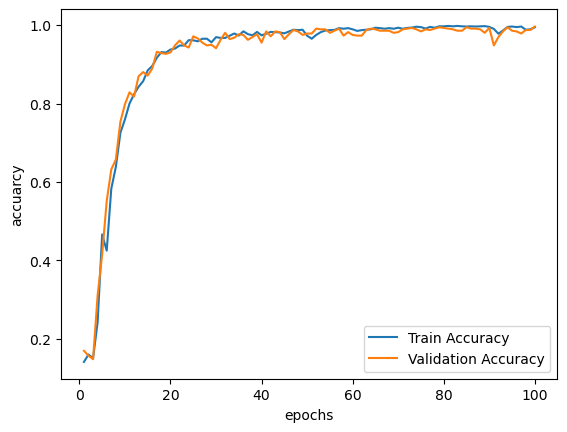

In [32]:
epochs=np.arange(1,101)
acc=history.history["accuracy"]
val_acc=history.history["val_accuracy"]

plt.plot(epochs,acc,label="Train Accuracy")
plt.plot(epochs,val_acc,label="Validation Accuracy")
plt.ylabel("accuarcy")
plt.xlabel("epochs")
plt.legend()
plt.show()

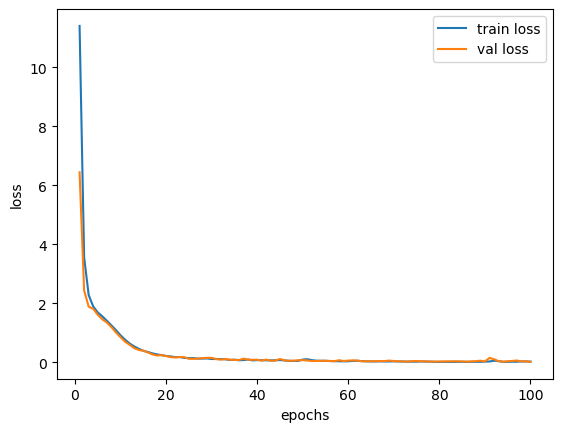

In [33]:
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(epochs, loss, label='train loss')
plt.plot(epochs, val_loss, label='val loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [34]:
paths = []
labels = []
for dirname, _, filenames in os.walk('C:\\Users\\HP\\split-dataset2\\test'):
    for filename in filenames:
        paths.append(os.path.join(dirname,filename))
        #print(filename)
        label=filename.split("_")[-1]
        #print(label)
        label=label.split(".")[0]
        labels.append(label.lower())
        #print(label.lower())
print("Dataset is loaded")

Dataset is loaded


In [35]:
#craetinga dataframe
df_test=pd.DataFrame()
df_test["Speech"]=paths
df_test["Labels"]=labels
df_test.head()

,Speech,Labels
0,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
1,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
2,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
3,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
4,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry


In [36]:
x_mfcc_test=df_test["Speech"].apply(lambda x: extract_mfcc(x))

In [37]:
x_mfcc_test

0      [-405.55737, 81.68523, -4.52156, -28.166002, 3...
1      [-464.8119, 70.25581, 10.510636, -12.559641, -...
2      [-399.28394, 81.14322, 8.215181, -7.010703, -1...
3      [-434.54526, 82.24351, 17.994444, -10.9224205,...
4      [-428.4799, 96.80968, -12.797659, -25.83548, -...
                             ...                        
275    [-406.48053, 80.379875, 32.462395, 46.579094, ...
276    [-426.90918, 102.54756, 24.800041, 43.048096, ...
277    [-378.50494, 80.91062, 35.300533, 39.74792, -4...
278    [-434.8618, 89.906364, 28.373262, 39.57707, -2...
279    [-421.8341, 70.69788, 32.476387, 45.642555, 4....
Name: Speech, Length: 280, dtype: object

In [38]:
X_test=[x for x in x_mfcc_test]
X_test=np.array(X_test)
X_test.shape

(280, 50)

In [39]:
y_test=enc.fit_transform(df_test[["Labels"]])

In [40]:
y_test=y_test.toarray()
y_test

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [41]:
y_pred=model.predict(X_test)

9/9 [==============================] - 1s 28ms/step


In [42]:
y_pred

array([[9.9999964e-01, 8.3826607e-18, 3.3996346e-09, ..., 5.5883725e-10,
        1.9107942e-09, 2.8324385e-10],
       [1.0000000e+00, 5.4148388e-17, 2.7598122e-09, ..., 8.3980456e-10,
        5.5796257e-08, 2.0530620e-10],
       [9.9999022e-01, 4.8392004e-15, 3.0734590e-09, ..., 5.2065730e-10,
        2.7890925e-08, 1.1562088e-09],
       ...,
       [3.3938209e-06, 2.8505344e-06, 7.4086557e-07, ..., 2.9347930e-07,
        3.7183489e-11, 9.9998415e-01],
       [1.2271393e-06, 2.2836055e-06, 7.8861168e-10, ..., 2.9928373e-07,
        2.5967559e-12, 9.9999583e-01],
       [4.4447867e-07, 4.1823932e-07, 2.5516316e-08, ..., 4.0110444e-07,
        9.5750979e-13, 9.9999809e-01]], dtype=float32)

In [43]:
emo_arr=np.array(["angry","disgust","fear","happy","neutral","ps","sad"])
df_test

,Speech,Labels
0,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
1,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
2,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
3,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
4,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry
...,...,...
275,C:\Users\HP\split-dataset2\test\YAF_sad\YAF_wi...,sad
276,C:\Users\HP\split-dataset2\test\YAF_sad\YAF_ye...,sad
277,C:\Users\HP\split-dataset2\test\YAF_sad\YAF_ye...,sad
278,C:\Users\HP\split-dataset2\test\YAF_sad\YAF_yo...,sad


In [44]:
emo_arr

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'ps', 'sad'],
      dtype='<U7')

In [45]:
l=[]
for a in y_pred:
    # print(a)
    z=a.argsort()
    l.append(emo_arr[z[-1]])
len(l)

280

In [46]:
df_test["Predicted"]=l

In [47]:
pd.set_option('display.max_rows',None)
df_test

,Speech,Labels,Predicted
0,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
1,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
2,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
3,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
4,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
5,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
6,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
7,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
8,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry
9,C:\Users\HP\split-dataset2\test\OAF_angry\OAF_...,angry,angry


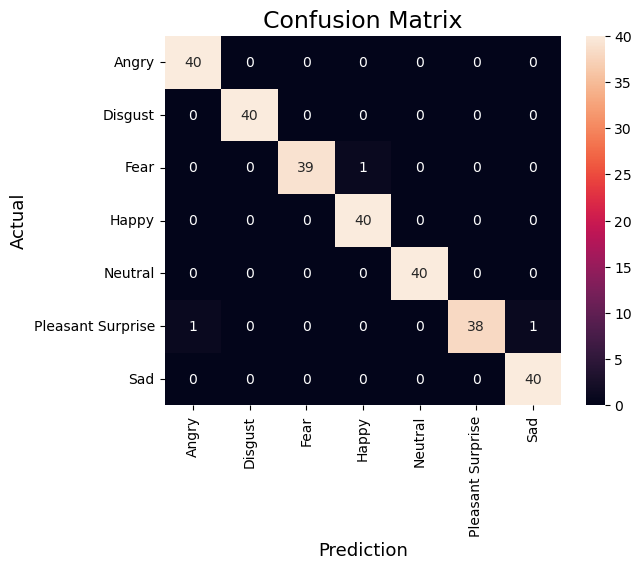

Accuracy   : 0.9892857142857143


In [48]:
#Import the necessary libraries 
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt 
 
#Create the NumPy array for actual and predicted labels.
actual    = df_test["Labels"]
predicted = df_test["Predicted"]
 
#compute the confusion matrix.
cm = confusion_matrix(actual,predicted)
 
#Plot the confusion matrix.
sns.heatmap(cm, 
            annot=True,
            fmt='g', 
            xticklabels=["Angry","Disgust","Fear","Happy","Neutral","Pleasant Surprise","Sad"],
            yticklabels=["Angry","Disgust","Fear","Happy","Neutral","Pleasant Surprise","Sad"])
plt.ylabel('Actual',fontsize=13)
plt.xlabel('Prediction',fontsize=13)
plt.title('Confusion Matrix',fontsize=17)
plt.show()

# Finding precision and recall
accuracy = accuracy_score(actual,predicted)
print("Accuracy   :", accuracy)